Fantastic explanation of the universal theorem of neural nets: http://neuralnetworksanddeeplearning.com/chap4.html.

This code approximates a complex function using an implementation of the universal theorem of neural nets. I also show a comparison to gradient descent.

Unfortunately, the theorem itself isn't very useful because the ideas needed to prove the theorem are heavily hand-constructed and can be done algorithmically but 1) are difficult to apply to real machine learning tasks and 2) fail to generalize. Also, approximating a function itself is not a difficult feat. Even Random Forest can approximate any function to any degree.

In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
torch.manual_seed(7) # reproducability

In [3]:
x = np.linspace(0, 1, 1000)
y = 0.2+0.4*x**2+0.3*x*np.sin(15*x)+0.05*np.cos(50*x) # some weird function

In [4]:
 # standardize
x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

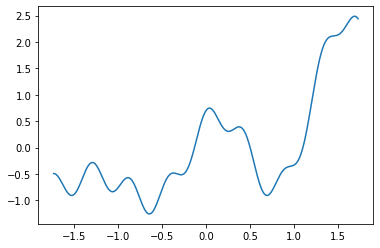

In [5]:
plt.plot(x, y)

# Sigmoid

In [6]:
# sigmoid function
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_torch(x):
    return 1/(1+torch.exp(-x))

## Sigmoid + Universal Theorem

In [7]:
# uses the universal theorem to create weights that can approx any function
class NN_Sigmoid_Approx:
    def __init__(self, num_bumps):
        self.nb = num_bumps
        self.w1 = np.zeros((1, 2*num_bumps))
        self.b1 = np.zeros((2*num_bumps))
        self.w2 = np.zeros((2*num_bumps, 1))
        self.b2 = np.zeros((1)) # this won't be modified
        
        self.cur_hid_neuron = 0
        
    def create_bump(self, xmin, xmax, amplitude):
        shw = 100
        shb = -xmin * shw

        ehw = 100
        ehb = -xmax * ehw
        
        # weight updates
        self.w1[0, self.cur_hid_neuron] = shw
        self.b1[self.cur_hid_neuron] = shb
        self.w2[self.cur_hid_neuron, 0] = amplitude
        self.cur_hid_neuron += 1
    
        self.w1[0, self.cur_hid_neuron] = ehw
        self.b1[self.cur_hid_neuron] = ehb
        self.w2[self.cur_hid_neuron, 0] = -amplitude
        self.cur_hid_neuron += 1        
        
    def get_nn_weights(self):
        return self.w1, self.b1, self.w2, self.b2

In [8]:
nnsa = NN_Sigmoid_Approx(5) # 5 bumps
nnsa.create_bump(-1.5, -1., -1.)
nnsa.create_bump(-0.8, -0.5, -1.2)
nnsa.create_bump(-0.2, 0.2, 1.)
nnsa.create_bump(0.3, 0.9, -1.)
nnsa.create_bump(1.2, 1.6, 2.2)

w1, b1, w2, b2 = nnsa.get_nn_weights()

In [9]:
inp = x.reshape(-1,1)
preds = (sigmoid(inp @ w1 + b1)) @ w2 + b2

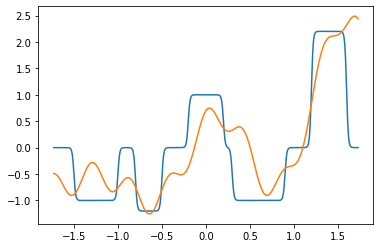

In [10]:
plt.plot(x, preds)
plt.plot(x, y)

In [11]:
r2_score(preds, y)

0.51418694179881

## Sigmoid + gradient descent

In [12]:
# this uses torch for backprop
x_train = torch.FloatTensor(x.reshape(-1,1))
y_train = torch.FloatTensor(y.reshape(-1,1))

# initialize torch variables
w1 = Variable(torch.randn(1, 27), requires_grad=True)
b1 = Variable(torch.randn(27), requires_grad=True)

w2 = Variable(torch.randn(27, 1), requires_grad=True)
b2 = Variable(torch.randn(1), requires_grad=True)

In [13]:
lr = 1e-4
epochs = 50
losses = []

for _ in range(epochs):
    layer1 = sigmoid_torch(x_train @ w1 + b1)
    layer2 = (layer1 @ w2 + b2)
    loss = ((layer2 - y_train)**2).sum() # MSE loss
    loss.backward()
    losses.append(loss.detach().numpy())

    w1 = Variable(w1 - w1.grad * lr, requires_grad=True)
    b1 = Variable(b1 - b1.grad * lr, requires_grad=True)

    w2 = Variable(w2 - w2.grad * lr, requires_grad=True)
    b2 = Variable(b2 - b2.grad * lr, requires_grad=True)

In [14]:
layer1 = sigmoid_torch(x_train @ w1 + b1)
preds = (layer1 @ w2 + b2)

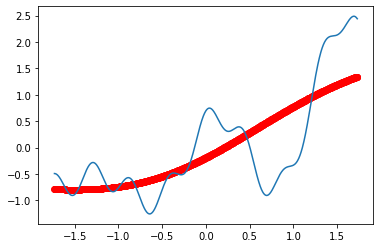

In [15]:
plt.scatter(x, preds.detach().numpy(), color='r')
plt.plot(x, y)

In [16]:
r2_score(preds.detach().numpy(), y)

0.1417805712449639

# Relu

In [17]:
# works for torch and numpy!
def relu(x):
    x[x<0] = 0
    return x

In [18]:
class NN_Relu_Approx:
    def __init__(self, num_lines):
        self.nl = 2*num_lines
        self.w1 = np.zeros((1, 2*num_lines))
        self.b1 = np.zeros((2*num_lines))
        self.w2 = np.zeros((2*num_lines, 1))
        self.b2 = np.zeros((1)) # this won't be modified
        
        self.cur_hid_neuron = 0
        
    def create_line(self, point1, point2):
        x1, y1 = point1
        x2, y2 = point2
        
        # make sure x1 < x2
        if x2 < x1:
            x1, x2 = x2, x1
            y1, y2 = y2, y1
        
        desired_slope = (y2-y1)/(x2-x1)
        
        start_x = x1
        end_x = x2
        if start_x > end_x:
            start_x, end_x = end_x, start_x
            desired_slope = -desired_slope
                    
        # weight updates
        # 1st hidden node
        self.w1[0, self.cur_hid_neuron] = 1
        self.b1[self.cur_hid_neuron] = -start_x
        self.w2[self.cur_hid_neuron, 0] = desired_slope
        self.cur_hid_neuron += 1
        
        # 2nd hidden node (cancels 1st out at end_x)
        self.w1[0, self.cur_hid_neuron] = 1
        self.b1[self.cur_hid_neuron] = -end_x
        self.w2[self.cur_hid_neuron, 0] = -desired_slope
        self.cur_hid_neuron += 1
        
    def get_nn_weights(self):
        return self.w1, self.b1, self.w2, self.b2

In [19]:
nnra = NN_Relu_Approx(5)
nnra.create_line((-2.0, 0.0), (-1.5, -1.0))
nnra.create_line((-1.5, -1.0), (-0.5, -1.0))
nnra.create_line((-0.5, -1.0), (0.0, 0.8))
nnra.create_line((0.0, 0.8), (0.6, -1.0))
nnra.create_line((0.6, -1.0), (1.5, 2.5))
w1, b1, w2, b2 = nnra.get_nn_weights()

In [20]:
inp = x.reshape(-1,1)
preds = (relu(inp @ w1 + b1)) @ w2 + b2

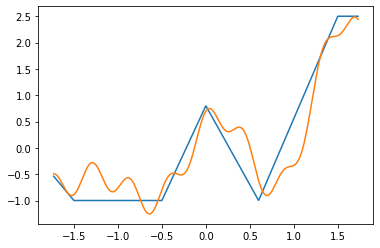

In [21]:
plt.plot(x, preds)
plt.plot(x, y)

In [22]:
r2_score(preds, y)

0.8620703630550125

## Sigmoid + gradient descent

In [23]:
# this uses torch for backprop
x_train = torch.FloatTensor(x.reshape(-1,1))
y_train = torch.FloatTensor(y.reshape(-1,1))

# initialize torch variables
w1 = Variable(torch.randn(1, 27), requires_grad=True)
b1 = Variable(torch.randn(27), requires_grad=True)

w2 = Variable(torch.randn(27, 1), requires_grad=True)
b2 = Variable(torch.randn(1), requires_grad=True)

In [24]:
lr = 1e-4
epochs = 50
losses = []

for _ in range(epochs):
    layer1 = relu(x_train @ w1 + b1)
    layer2 = (layer1 @ w2 + b2)
    loss = ((layer2 - y_train)**2).sum() # MSE loss
    loss.backward()
    losses.append(loss.detach().numpy())

    w1 = Variable(w1 - w1.grad * lr, requires_grad=True)
    b1 = Variable(b1 - b1.grad * lr, requires_grad=True)

    w2 = Variable(w2 - w2.grad * lr, requires_grad=True)
    b2 = Variable(b2 - b2.grad * lr, requires_grad=True)

In [25]:
layer1 = relu(x_train @ w1 + b1)
preds = (layer1 @ w2 + b2)

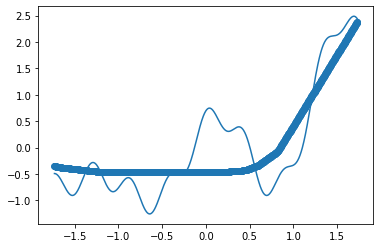

In [26]:
plt.scatter(x, preds.detach().numpy())
plt.plot(x, y)

In [27]:
r2_score(preds.detach().numpy(), y)

0.5274453835181994